In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from smt.surrogate_models import KRG
from juliacall import Main as jl
from mpl_toolkits.mplot3d import Axes3D
# import plotly.graph_objs as go

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
### CREATE DATA ARRAY ###

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
one_file = ["naca0012.dat"]
camber_files = ["naca0012.dat", "naca2412.dat", "naca4412.dat", "naca6412.dat"]
thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat", "naca0024.dat"]

# Select which files to use
list_of_files =  thickness_files

# Set parameters
alpha = list(range(-16, 20, 2))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

print(thickness_values)

    

[ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.]


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 90
   
___________________________________________________________________________
   
 Training
   
   Training ...


   Training - done. Time (sec):  3.5127509
[ 9.          9.15151515  9.3030303   9.45454545  9.60606061  9.75757576
  9.90909091 10.06060606 10.21212121 10.36363636 10.51515152 10.66666667
 10.81818182 10.96969697 11.12121212 11.27272727 11.42424242 11.57575758
 11.72727273 11.87878788 12.03030303 12.18181818 12.33333333 12.48484848
 12.63636364 12.78787879 12.93939394 13.09090909 13.24242424 13.39393939
 13.54545455 13.6969697  13.84848485 14.         14.15151515 14.3030303
 14.45454545 14.60606061 14.75757576 14.90909091 15.06060606 15.21212121
 15.36363636 15.51515152 15.66666667 15.81818182 15.96969697 16.12121212
 16.27272727 16.42424242 16.57575758 16.72727273 16.87878788 17.03030303
 17.18181818 17.33333333 17.48484848 17.63636364 17.78787879 17.93939394
 18.09090909 18.24242424 18.39393939 18.54545455 18.6969697  18.84848485
 19.         19.15151515 19.3030303  19.45454545 19.60606061 19.75757576
 19.90909091 20.06060606 20.21212121 20.36363636 20.51515152 20.66666667
 20.81818

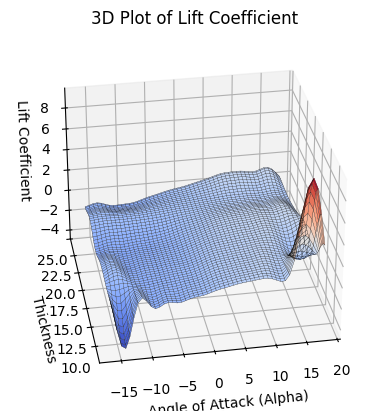

In [4]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and thickness plot # attempt thickness
xt = np.column_stack((alpha_values, thickness_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
thickness = np.linspace(thickness_min, thickness_max, 100)
print(thickness)
alpha_grid, thickness_grid = np.meshgrid(alpha, thickness)
xt_grid = np.c_[alpha_grid.ravel(), thickness_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, thickness_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, thickness_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Thickness')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 90
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  3.4675381
[ 9.          9.15151515  9.3030303   9.45454545  9.60606061  9.75757576
  9.90909091 10.06060606 10.21212121 10.36363636 10.51515152 10.66666667
 10.81818182 10.96969697 11.12121212 11.27272727 11.42424242 11.57575758
 11.72727273 11.87878788 12.03030303 12.18181818 12.33333333 12.48484848
 12.63636364 12.78787879 12.93939394 13.09090909 13.24242424 13.39393939
 13.54545455 13.6969697  13.84848485 14.         14.15151515 14.3030303
 14.45454545 14.60606061 14.75757576 14.90909091 15.06060606 15.21212121
 15.36363636 15.51515152 15.66666667 15.81818182 15.96969697 16.12121212
 16

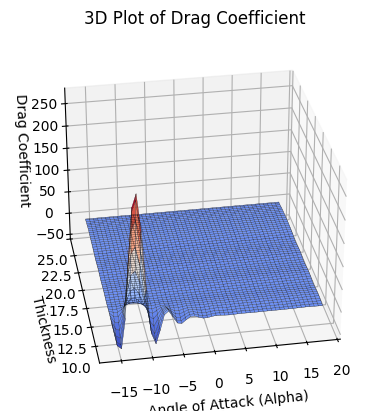

In [5]:
### CHOOSE DRAG COEFFICIENT ###

# Choose which coefficient to plot
focus = "drag"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and thickness plot # attempt thickness
xt = np.column_stack((alpha_values, thickness_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
thickness = np.linspace(thickness_min, thickness_max, 100)
print(thickness)
alpha_grid, thickness_grid = np.meshgrid(alpha, thickness)
xt_grid = np.c_[alpha_grid.ravel(), thickness_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, thickness_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, thickness_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Thickness')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 144
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.5478556
[ 9.          9.09090909  9.18181818  9.27272727  9.36363636  9.45454545
  9.54545455  9.63636364  9.72727273  9.81818182  9.90909091 10.
 10.09090909 10.18181818 10.27272727 10.36363636 10.45454545 10.54545455
 10.63636364 10.72727273 10.81818182 10.90909091 11.         11.09090909
 11.18181818 11.27272727 11.36363636 11.45454545 11.54545455 11.63636364
 11.72727273 11.81818182 11.90909091 12.         12.09090909 12.18181818
 12.27272727 12.36363636 12.45454545 12.54545455 12.63636364 12.72727273
 12.81818182 12.90909091 13.         13.09090909 13.18181818 13.27272727
 13.36363

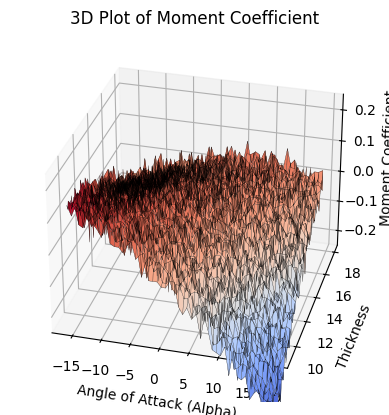

In [ ]:
### CHOOSE MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "moment"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and thickness plot # attempt thickness
xt = np.column_stack((alpha_values, thickness_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
thickness = np.linspace(thickness_min, thickness_max, 100)
print(thickness)
alpha_grid, thickness_grid = np.meshgrid(alpha, thickness)
xt_grid = np.c_[alpha_grid.ravel(), thickness_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, thickness_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, thickness_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Thickness')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=285)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

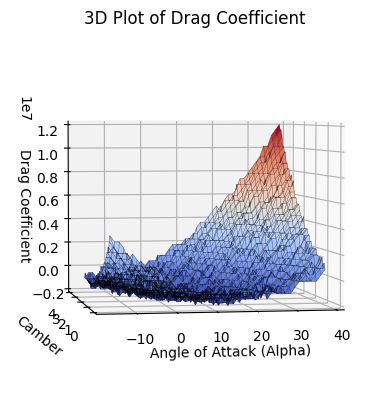

In [ ]:
### JUST PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=3, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 144
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  3.3093030
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 5000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0563574
   
   Prediction time/pt. (sec) :  0.0000113
   


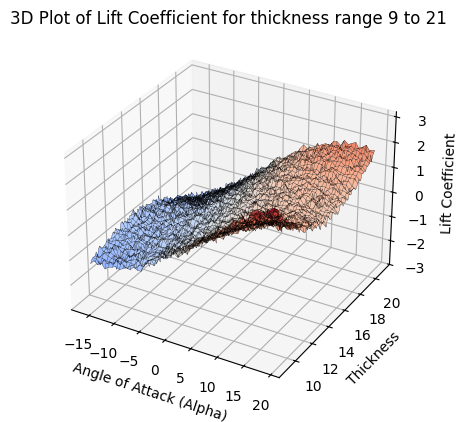

In [ ]:
### TRY PLOTTING 3D ###

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from smt.surrogate_models import KRG

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]

# Select which files to use
list_of_files = thickness_files

# Set parameters
alpha = list(range(-16, 20, 1))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create a grid of thickness values within the specified range
thickness_range = np.linspace(9, 21, 100)

# Create the surrogate model for the entire dataset
xt = np.column_stack((alpha_values, thickness_values))
if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"

model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha_grid = np.linspace(min(alpha_values), max(alpha_values), 50)
alpha_grid, thickness_grid = np.meshgrid(alpha_grid, thickness_range)
xt_grid = np.c_[alpha_grid.ravel(), thickness_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

# Plot the model
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, thickness_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, thickness_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Thickness')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel} for thickness range 9 to 21')

# Show the plot
plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 144
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  3.2108157
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
___________________________________________________________________________
   
 Evaluation
   
      # eva

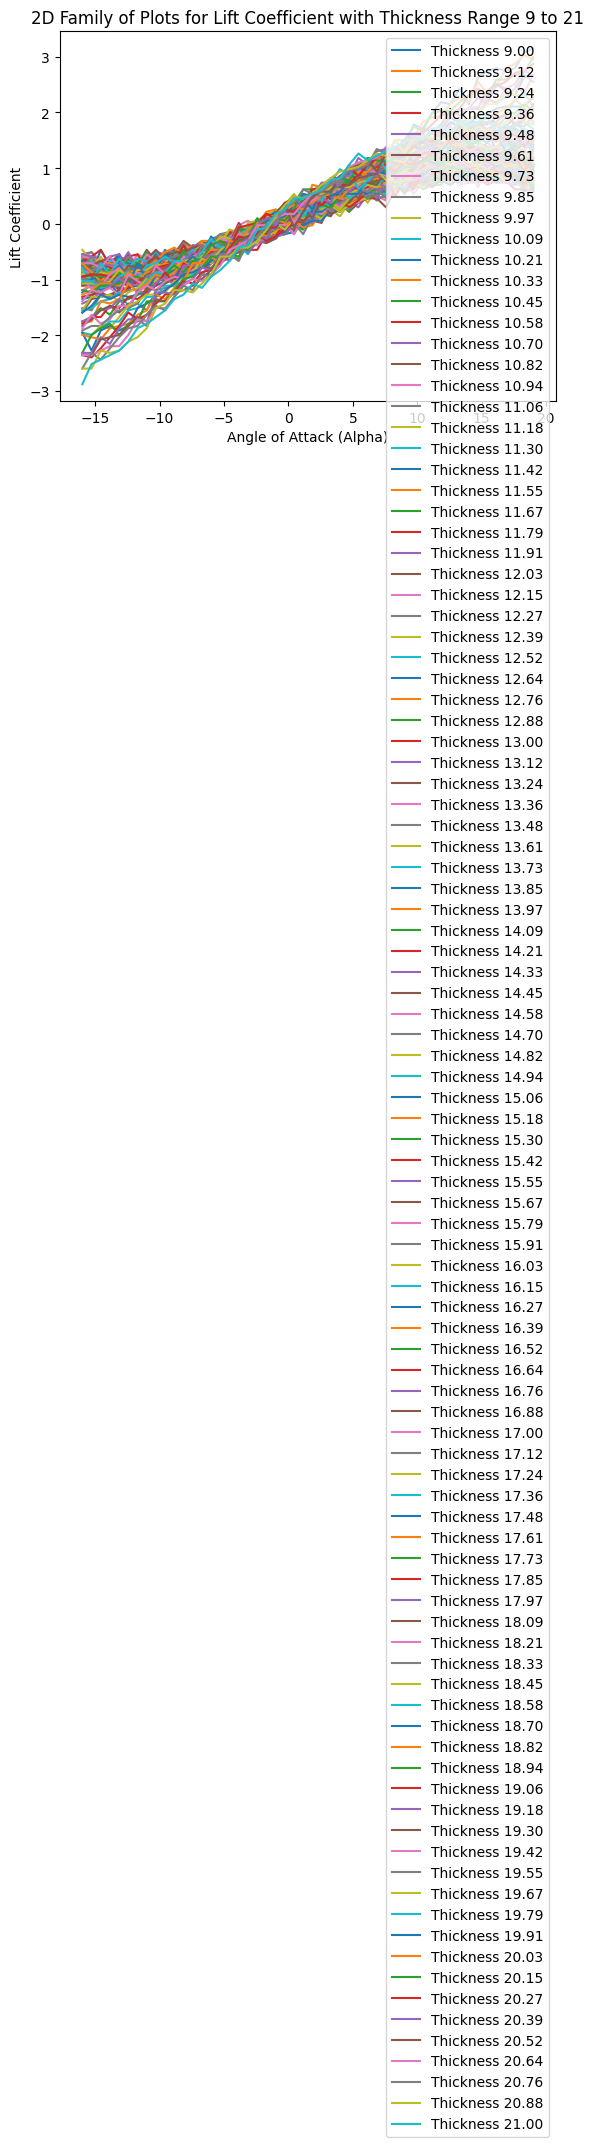

In [ ]:
### TRY PLOTTING FAMILY OF CURVES ###

import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
# thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]

# Select which files to use
list_of_files = thickness_files

# Set parameters
alpha = list(range(-16, 20, 1))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create the surrogate model for the entire dataset
xt = np.column_stack((alpha_values, thickness_values))
if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"

model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha_grid = np.linspace(min(alpha_values), max(alpha_values), 50)
thickness_range = np.linspace(9, 21, 100)

# Plot the model
plt.figure()

for thickness in np.unique(thickness_values):
    thickness_grid = np.full_like(alpha_grid, thickness)
    xt_grid = np.column_stack((alpha_grid, thickness_grid))
    yt_grid = model.predict_values(xt_grid)

    plt.plot(alpha_grid, yt_grid, label=f'Thickness {thickness:.2f}')

plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel(zlabel)
plt.title(f'Kriging Lift Plot for with Different Thickness')
plt.legend()
plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 36
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.3559763
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009973
   
   Prediction time/pt. (sec) :  0.0000199
   


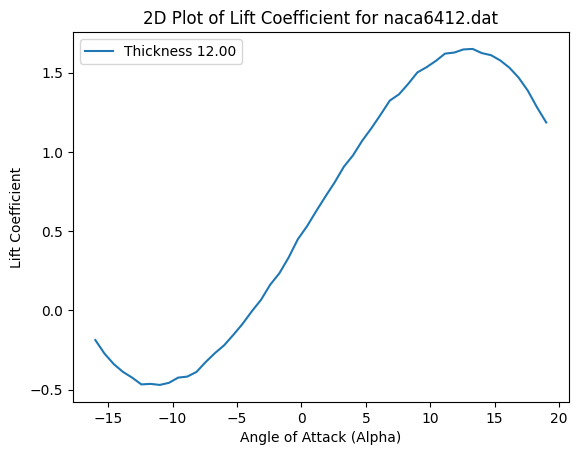

In [3]:
### TRY JUST PLOTTING ONE NACA FILE ###
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Select the specific NACA file to use
naca_file = "naca6412.dat"

# Set parameters
alpha = list(range(-16, 20, 1))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, [naca_file])
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create the surrogate model for the entire dataset
xt = np.column_stack((alpha_values, thickness_values))
if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"

model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha_grid = np.linspace(min(alpha_values), max(alpha_values), 50)
thickness_grid = np.full_like(alpha_grid, thickness_values[0])  # Use the thickness value from the specific NACA file
xt_grid = np.column_stack((alpha_grid, thickness_grid))
yt_grid = model.predict_values(xt_grid)

# Plot the model
plt.figure()
plt.plot(alpha_grid, yt_grid, label=f'Thickness {thickness_values[0]:.2f}')

plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel(zlabel)
plt.title(f'2D Plot of {zlabel} for {naca_file}')
plt.legend()
plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 36
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2525654
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009971
   
   Prediction time/pt. (sec) :  0.0000199
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 36
   
___________________________________________________________________________
   
 Train

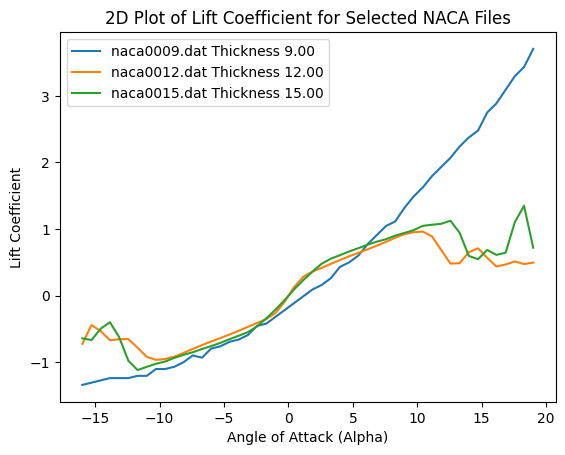

In [ ]:
### TRY MULTIPLE NACA CURVES ###

import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Select the specific NACA files to use
naca_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat"]

# Set parameters
alpha = list(range(-16, 20, 1))  # range of angle of attacks, in degrees
re = 1e5

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Plot the model for each NACA file
plt.figure()

for naca_file in naca_files:
    # Convert Python list to Julia array
    julia_list_of_files = jl.convert(jl.Array, [naca_file])
    julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

    # Get data from julia
    julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

    # Create numpy array from julia data, make sure type is float
    data_array = np.array(julia_data, dtype=float)

    columns = {
        "alpha": 0,
        "c_l": 1,
        "c_d": 2,
        "c_dp": 3,
        "c_m": 4,
        "converged": 5,
        "camber": 6,
        "thickness": 7
    }

    # Access data using column names
    alpha_values = data_array[:, columns["alpha"]]
    c_l_values = data_array[:, columns["c_l"]]
    c_d_values = data_array[:, columns["c_d"]]
    c_dp_values = data_array[:, columns["c_dp"]]
    c_m_values = data_array[:, columns["c_m"]]
    converged_values = data_array[:, columns["converged"]]
    camber_values = data_array[:, columns["camber"]]
    thickness_values = data_array[:, columns["thickness"]]

    # Create the surrogate model for the entire dataset
    xt = np.column_stack((alpha_values, thickness_values))
    if focus == "lift":
        yt = c_l_values
        zlabel = "Lift Coefficient"
    elif focus == "drag":
        yt = c_d_values
        zlabel = "Drag Coefficient"
    elif focus == "moment":
        yt = c_m_values
        zlabel = "Moment Coefficient"

    model = KRG()
    model.set_training_values(xt, yt)
    model.train()

    # Create grid for prediction
    alpha_grid = np.linspace(min(alpha_values), max(alpha_values), 50)
    thickness_grid = np.full_like(alpha_grid, thickness_values[0])  # Use the thickness value from the specific NACA file
    xt_grid = np.column_stack((alpha_grid, thickness_grid))
    yt_grid = model.predict_values(xt_grid)

    # Plot the model
    plt.plot(alpha_grid, yt_grid, label=f'{naca_file} Thickness {thickness_values[0]:.2f}')

plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel(zlabel)
plt.title(f'2D Plot of {zlabel} for Selected NACA Files')
plt.legend()
plt.show()